## creating a gdf with 10m squares

In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# geo dfs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster data
import rioxarray as rxr
import rasterio as rio

In [31]:
rds = rxr.open_rasterio("..\\data\\rivm-lden\\rivm_20220601_Geluid_lden_allebronnen_2020_v2.tif")
rds.name = "dba_rivm"
print(rds.shape)
rds = rds.rio.clip_box(minx=129739.1234,miny=450112.6341,
                        maxx=142817.4583,maxy=461586.9908)
print(rds.shape)


(1, 31200, 26400)
(1, 1148, 1309)


In [32]:
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

In [33]:
gdf= gdf[['y', 'x', 'dba_rivm', 'geometry']]
gdf

,y,x,dba_rivm,geometry
0,461585.0,129735.0,50,POINT (129735.000 461585.000)
1,461585.0,129745.0,50,POINT (129745.000 461585.000)
2,461585.0,129755.0,51,POINT (129755.000 461585.000)
3,461585.0,129765.0,51,POINT (129765.000 461585.000)
4,461585.0,129775.0,51,POINT (129775.000 461585.000)
...,...,...,...,...
1502727,450115.0,142775.0,59,POINT (142775.000 450115.000)
1502728,450115.0,142785.0,62,POINT (142785.000 450115.000)
1502729,450115.0,142795.0,66,POINT (142795.000 450115.000)
1502730,450115.0,142805.0,66,POINT (142805.000 450115.000)


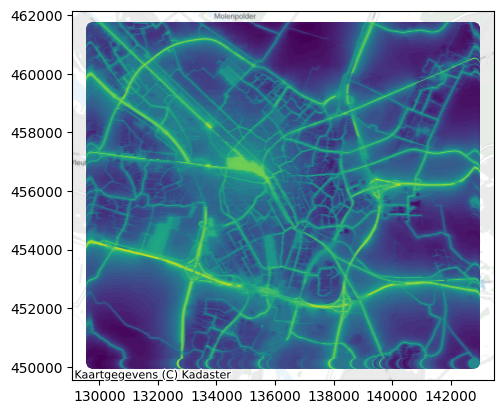

In [12]:
ax = gdf.plot(column = 'data')
cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)
# takes 90 seconds

In [26]:
gdf_aud = gpd.read_file('..\\datacollection\\gdf_aud.gpkg', engine='pyogrio', use_arrow=True)
gdf_aud = gdf_aud.rename(columns={'DbA': 'dba_measured', 'DbA_adjusted_ols': 'dba_adj_lin'})
gdf_aud

,DateTime,Longitude,Latitude,speed,dba_measured,dba_adj_lin,is_fast,geometry
0,2024-05-08 08:14:45+00:00,5.182616,52.090183,24.445303,81.086515,68.121409,False,POINT (140978.895 455789.077)
1,2024-05-08 08:14:46+00:00,5.182682,52.090099,26.134887,80.752247,66.891032,False,POINT (140983.369 455779.691)
2,2024-05-08 08:14:47+00:00,5.182701,52.090000,30.396279,82.491447,66.370108,True,POINT (140984.610 455768.702)
3,2024-05-08 08:14:48+00:00,5.182719,52.089902,26.152667,85.747267,71.876622,False,POINT (140985.829 455757.740)
4,2024-05-08 08:14:49+00:00,5.182782,52.089818,25.002250,83.261453,70.000957,False,POINT (140990.104 455748.375)
...,...,...,...,...,...,...,...,...
8948,2024-05-08 10:52:35+00:00,5.181900,52.082204,8.172631,66.084966,61.750431,False,POINT (140927.287 454901.387)
8949,2024-05-08 10:52:36+00:00,5.181900,52.082219,8.012524,64.749939,60.500320,False,POINT (140927.292 454903.149)
8950,2024-05-08 10:52:37+00:00,5.181900,52.082283,7.856735,64.326809,60.159816,False,POINT (140927.312 454910.188)
8951,2024-05-08 10:52:38+00:00,5.181900,52.082299,6.541815,64.321462,60.851866,False,POINT (140927.317 454912.038)


In [34]:
gdf_nearest = gpd.sjoin_nearest(gdf, gdf_aud[['geometry', 'dba_measured', 'dba_adj_lin', 'speed']],
                        how='right') # note both gdf's are in ECRS 28992
gdf_nearest

,index_left,y,x,dba_rivm,geometry,dba_measured,dba_adj_lin,speed
0,760344,455785.0,140975.0,59,POINT (140978.895 455789.077),81.086515,68.121409,24.445303
1,761654,455775.0,140985.0,59,POINT (140983.369 455779.691),80.752247,66.891032,26.134887
2,762963,455765.0,140985.0,58,POINT (140984.610 455768.702),82.491447,66.370108,30.396279
3,764272,455755.0,140985.0,57,POINT (140985.829 455757.740),85.747267,71.876622,26.152667
4,765582,455745.0,140995.0,57,POINT (140990.104 455748.375),83.261453,70.000957,25.002250
...,...,...,...,...,...,...,...,...
8948,875531,454905.0,140925.0,45,POINT (140927.287 454901.387),66.084966,61.750431,8.172631
8949,875531,454905.0,140925.0,45,POINT (140927.292 454903.149),64.749939,60.500320,8.012524
8950,874222,454915.0,140925.0,45,POINT (140927.312 454910.188),64.326809,60.159816,7.856735
8951,874222,454915.0,140925.0,45,POINT (140927.317 454912.038),64.321462,60.851866,6.541815


In [2]:
import libpysal as ps
import numpy as np
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW

data = ps.io.open(ps.examples.get_path('GData_utm.csv'))

coords = list(zip(data.by_col('X'), data.by_col('Y')))

y = np.array(data.by_col('PctBach')).reshape((-1,1))

rural = np.array(data.by_col('PctRural')).reshape((-1,1))

fb = np.array(data.by_col('PctFB')).reshape((-1,1))

african_amer = np.array(data.by_col('PctBlack')).reshape((-1,1))

X = np.hstack([fb, african_amer, rural])

X = (X - X.mean(axis=0)) / X.std(axis=0)

y = (y - y.mean(axis=0)) / y.std(axis=0)

selector = Sel_BW(coords, y, X, multi=True)

selector.search(multi_bw_min=[2])
[92.0, 101.0, 136.0, 158.0]

model = MGWR(coords, y, X, selector, fixed=False, kernel='bisquare', sigma2_v1=True)

results = model.fit()

print(results.params.shape)
(159, 4)

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Inference: 100%|██████████| 1/1 [00:00<?, ?it/s]

(159, 4)


(159, 4)

In [8]:
print(results.params)

[[-0.19724851  0.29455637 -0.04527794 -0.33124349]
 [-0.25339381  0.22802268 -0.02666017 -0.32531232]
 [-0.21977661  0.27957193 -0.03733625 -0.33029039]
 [-0.16768195  0.1453812  -0.02704666 -0.28682396]
 [ 0.16535579  0.679053   -0.14010958 -0.29561428]
 [ 0.22220771  0.71754535 -0.07694133 -0.30491092]
 [ 0.2389517   0.72061584 -0.08214949 -0.30233707]
 [ 0.12793802  0.70617787 -0.04542356 -0.29714775]
 [-0.22263906  0.28813137 -0.04073719 -0.31422505]
 [-0.25146477  0.19213303 -0.02462087 -0.31835925]
 [ 0.10145225  0.54842755 -0.11731045 -0.28634981]
 [-0.03374     0.39719718 -0.09261651 -0.29830004]
 [-0.21317327  0.26156865 -0.02684146 -0.33920295]
 [-0.24974482  0.14068982 -0.01777999 -0.3149756 ]
 [-0.12862125  0.32404775 -0.06792543 -0.342906  ]
 [-0.07817469  0.37848732 -0.09460406 -0.33649771]
 [ 0.06584966  0.55570107 -0.13324316 -0.3246506 ]
 [ 0.20707898  0.67042035 -0.11069834 -0.2929783 ]
 [-0.13925488  0.16244908 -0.03361903 -0.27895405]
 [-0.21079419  0.25348636 -0.02

In [36]:
results

In [40]:
X

array([[-3.98516575e-01, -3.82805697e-01,  2.00641207e-01],
       [ 3.64222409e-01, -3.07649962e-02,  1.10387586e+00],
       [-6.98743622e-01, -6.90985589e-01, -3.13906405e-01],
       [-8.28571534e-01,  1.40105956e+00,  1.10387586e+00],
       [ 2.42508742e-01,  8.65496000e-01, -1.01724487e+00],
       [-6.41943910e-01, -1.37948486e+00,  1.10387586e+00],
       [-1.71317729e-01, -9.20677718e-01, -2.06554745e-01],
       [-2.52460174e-01, -1.04937456e+00,  1.85834082e-01],
       [-6.50058155e-01,  2.27205812e-01, -8.58068268e-01],
       [ 4.77668734e-02, -9.10289632e-01, -1.47326243e-01],
       [-5.77183053e-02,  8.24520771e-01, -2.00191871e+00],
       [-3.98516575e-01, -2.90467152e-01, -4.54574097e-01],
       [-6.50058155e-01, -1.31657923e+00,  1.10387586e+00],
       [ 5.10278811e-01,  8.12401337e-01, -1.69536931e-01],
       [-5.52687221e-01, -7.23881195e-01,  3.85730276e-01],
       [ 2.34241398e-02, -8.32825433e-02, -2.58379684e-01],
       [-5.68915710e-01,  1.43106958e+00